In [ ]:
from criminologia_cdmx.etl import *
from criminologia_cdmx.patrones_espacio_temporales import *
from criminologia_cdmx.covariables import *
from criminologia_cdmx.modelos import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import contextily as ctx
plt.style.use('ggplot')

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
carpetas = get_carpetas_desde_archivo("datos/descargas/carpetas_fiscalia.csv")
carpetas = agrega_ids_espaciales(carpetas)
fecha_inicio = "01-01-2019"
fecha_fin = "01-03-2020"
delito = ['ROBO A CASA HABITACION SIN VIOLENCIA']
Y = variable_dependiente(carpetas, 'delito', delito, fecha_inicio, fecha_fin)
diccionario = get_diccionario_censo()
censo = get_variables_censo()
agregado = agrega_en_unidades(censo, diccionario)
agregado = censo_a_tasas(agregado, diccionario)
vars_viv = agregado[['VIVPAR_HAB', 'VPH_3YMASC']]
vars_indice = ['P5_HLI', 'POB_AFRO', 'PCON_DISC', 'P3A5_NOA', 
               'P6A11_NOA', 'P12A14NOA', 'P15YM_AN', 'PSINDER', 'PDESOCUP']
indice = IndicePCA(agregado, vars_indice)
indice.calcula_indice()
var_m1 = (vars_viv
          .join(indice.indice.set_index('colonia_cve'))
          .rename({'Índice': 'Concentración de Desventajas'}, axis=1))
ca = CapaDeAnalisis(Y, var_m1, 'colonias')

In [ ]:
ca = CapaDeAnalisis(Y, var_m1, 'colonias')

# Modelo SLX (retraso espacial en X)

Ahora tenemos nuestra capa de análisis base, a parti de ella podemos construir una nueva agregando un retraso espacial en la variable `Concentración de Desventajas`

In [ ]:
# Primero creamos una copia de la capa original para usarla después
ca_cd_lag = ca.copy()
# Calculamos el retraso
ca_cd_lag = ca_cd_lag.retraso_x('Concentración de Desventajas')
ca_cd_lag.df.head()

,colonia_cve,ROBO A CASA HABITACION SIN VIOLENCIA,VIVPAR_HAB,VPH_3YMASC,Concentración de Desventajas,Concentración de Desventajas_lag
0,32,0.0,878.0,1.045558,-2.401170,-2.300612
1,619,9.0,1491.0,0.998659,-1.493854,-0.662141
2,1792,2.0,775.0,0.752258,3.328881,1.218451
3,1774,0.0,284.0,0.989437,-2.071739,-0.509785
4,583,13.0,2941.0,0.956477,-1.218791,-0.715362


El ajuste del modelo es igual que en el caso normal

In [ ]:
m_cd_lag = ModeloGLM(ca_cd_lag, sm.families.Poisson(), "Retraso CD")
r_cd_lag = m_cd_lag.fit()
r_cd_lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     Q('ROBO A CASA HABITACION SIN VIOLENCIA')   No. Observations:                 1807
Model:                                                   GLM   Df Residuals:                     1802
Model Family:                                        Poisson   Df Model:                            4
Link Function:                                           log   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -4263.6
Date:                                       Tue, 19 Apr 2022   Deviance:                       4254.3
Time:                                               16:45:02   Pearson chi2:                 4.20e+03
No. Iterations:                                            5                                         
Covariance Type:                                   nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.2001      0.069     -2.911      0.004      -0.335      -0.065
Q('VIVPAR_HAB')                           0.0005   7.25e-06     71.576      0.000       0.001       0.001
Q('VPH_3YMASC')                           0.5725      0.072      7.935      0.000       0.431       0.714
Q('Concentración de Desventajas')        -0.0396      0.012     -3.205      0.001      -0.064      -0.015
Q('Concentración de Desventajas_lag')    -0.1027      0.015     -6.754      0.000      -0.133      -0.073
=========================================================================================================
"""

Y ahora podemos ajustar el modelo con la capa sin retraso espacial y comparar los modelos

In [ ]:
m_cd = ModeloGLM(ca, sm.families.Poisson(), "Sin Retraso CD")
r_cd = m_cd.fit()
compara = ComparaModelos([m_cd, m_cd_lag], ['coef', 'P>|z|'], 3)
compara.comparacion

Modelo Sin Retraso CD        \
                                                       coef P>|z|   
Q('VPH_3YMASC')                                       0.627   0.0   
Q('Concentración de Desventajas_lag')                   NaN   NaN   
Q('VIVPAR_HAB')                                       0.001   0.0   
Q('Concentración de Desventajas')                    -0.096   0.0   
Intercept                                            -0.252   0.0   

                                      Modelo Retraso CD         
                                                   coef  P>|z|  
Q('VPH_3YMASC')                                   0.573  0.000  
Q('Concentración de Desventajas_lag')            -0.103  0.000  
Q('VIVPAR_HAB')                                   0.001  0.000  
Q('Concentración de Desventajas')                -0.040  0.001  
Intercept                                        -0.200  0.004

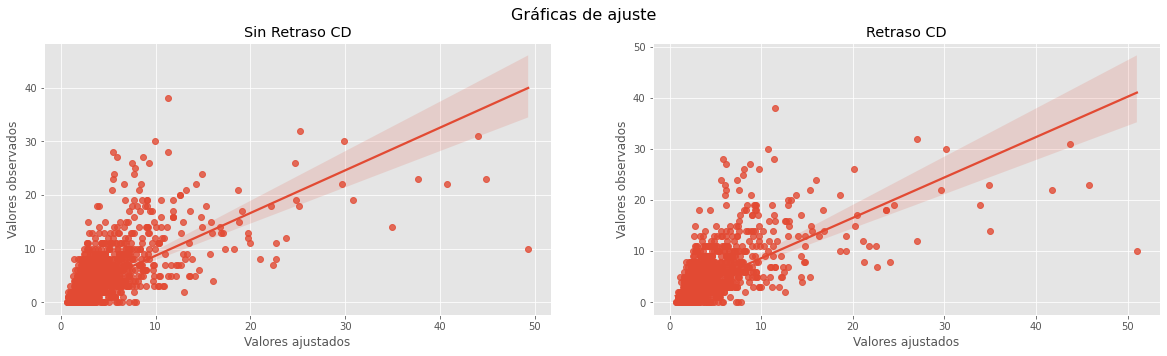

In [ ]:
compara.graficas_de_ajuste()

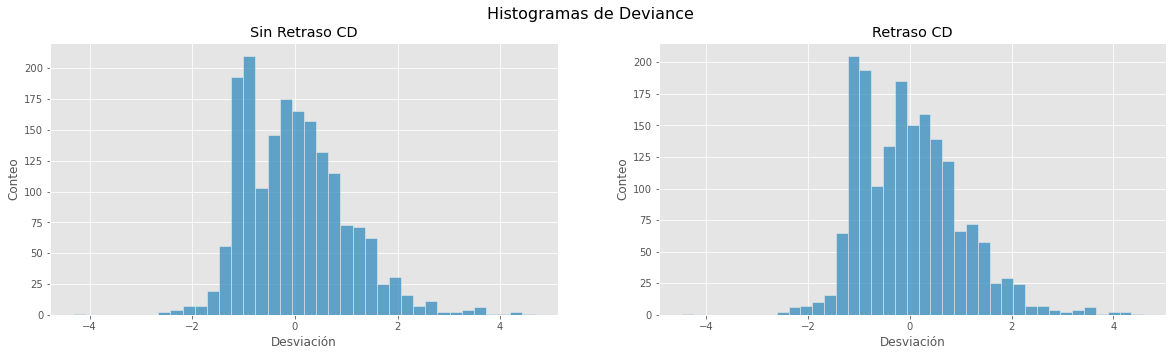

In [ ]:
compara.histogramas_deviance()

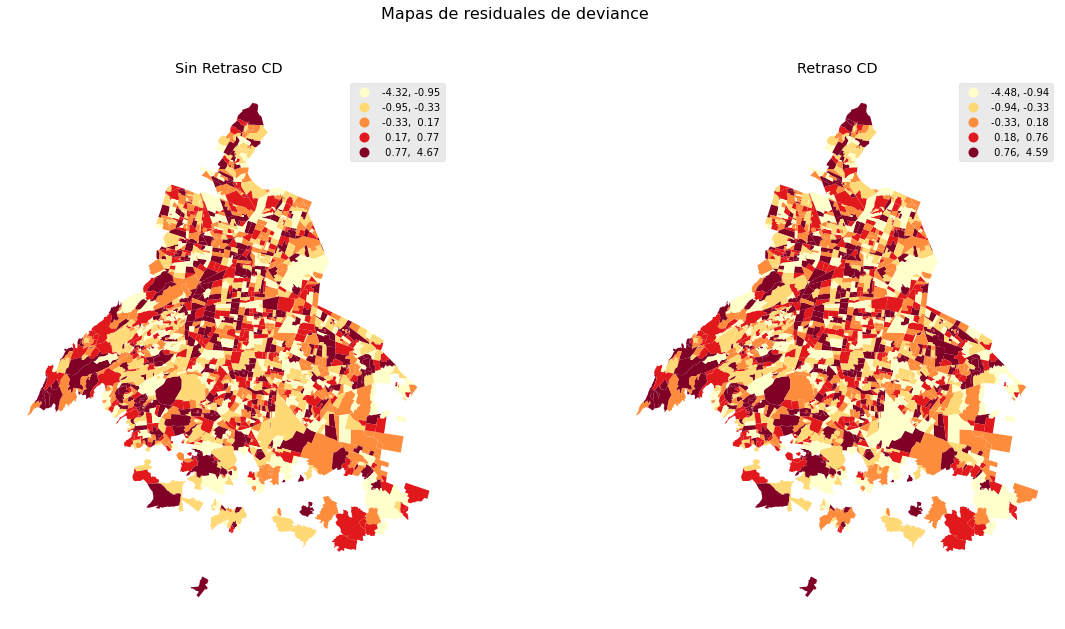

In [ ]:
compara.mapas_residuales()

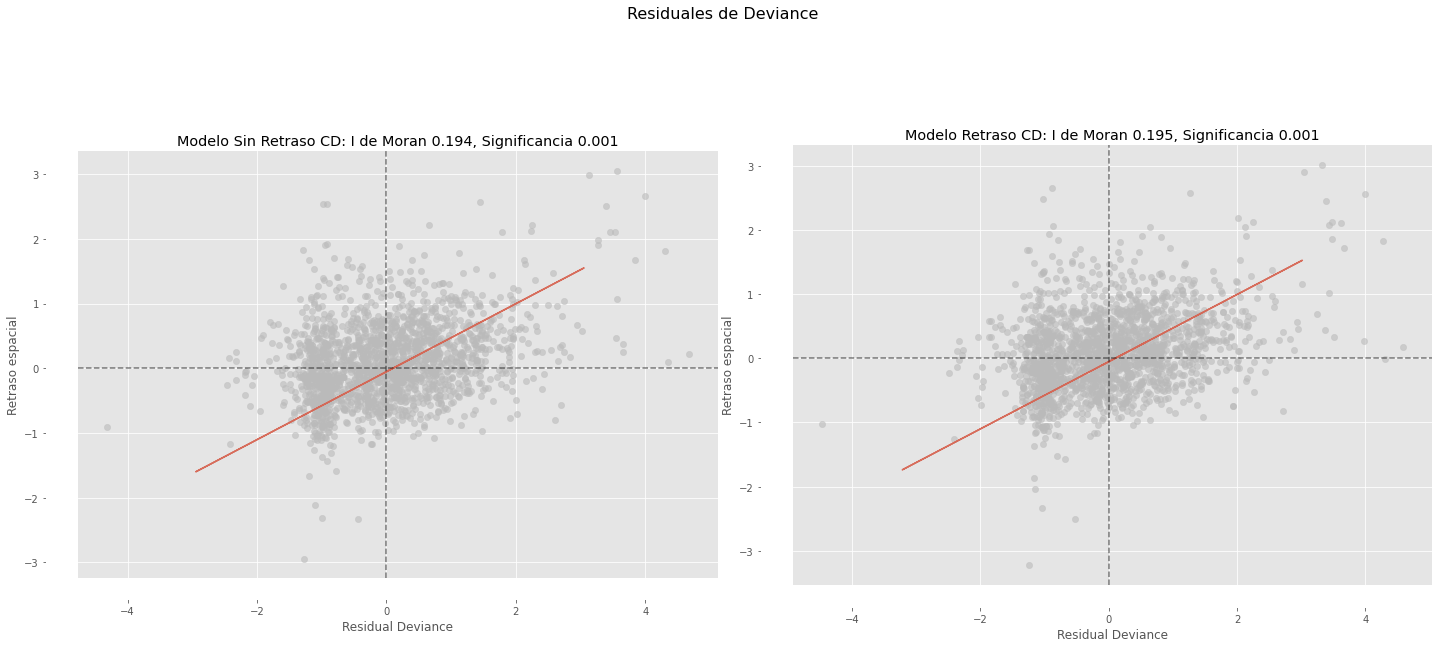

In [ ]:
compara.scatterpĺots_moran()